<a href="https://colab.research.google.com/github/nbalatamu/Hybrid-Dynamic-Models-for-Species-Dynamics/blob/main/GLV_on_Simulation_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
from tqdm.notebook import tqdm
import time
from sklearn.metrics import r2_score

%matplotlib inline

In [ ]:
!pip install torchdiffeq

In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from torchdiffeq import odeint_adjoint
import time

In [ ]:
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

set_random_seeds()

#Import Data

In [ ]:
# Load the dictionary from the pickle file
with open('results_simulation.pkl', 'rb') as f:
    sim_results = pickle.load(f)

In [ ]:
key = list(sim_results.keys())
sim_data = 1

In [ ]:
result = sim_results[sim_data]

e = result['e'].transpose(0, 1)
x = result['pred_y'].squeeze(1)
t = result['t']

#Train-Val-Test Split

In [ ]:
def data_split(x, e, test_size, val_size):

  #This function splits the data into train, validation, and test sets

  train_size = x.shape[0] - val_size - test_size

  train_x, train_e = x[:train_size], e[:train_size]
  val_x, val_e = x[train_size:train_size+val_size], e[train_size:train_size+val_size]
  test_x, test_e = x[train_size+val_size:], e[train_size+val_size:]

  return train_x, val_x, test_x, train_e, val_e, test_e

In [ ]:
#Data_split

val_time_points = 10
test_time_points = 10

train_time_points = x.shape[0] - val_time_points - test_time_points

train_x, val_x, test_x, train_e, val_e, test_e = data_split(x, e, test_time_points, val_time_points)

#Get Batches

In [ ]:
t_train = t[ : train_time_points]
t_val = t[ : train_time_points + val_time_points]
t_test = t[ : train_time_points + val_time_points + test_time_points]

In [ ]:
def get_batch(train_x, train_e, batch_time = 12, batch_size = 8):
  s = torch.from_numpy(np.random.choice(np.arange(train_time_points - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = train_x[s]  # (batch_size, 1, emb)
  batch_t = t_train[:batch_time]  # (T)
  batch_y = torch.stack([train_x[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, emb)
  batch_e = torch.stack([train_e[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, emb)
  return batch_y0, batch_t, batch_y, batch_e

#Model A - GLV Model

In [ ]:
# Define the combined ODE model
class GLVModel(nn.Module):
    def __init__(self, m):
        super(GLVModel, self).__init__()
        self.m = m

        self.net_1 = nn.Linear(m, m)

    def forward(self, t, x):
        return x * self.net_1(x)

#Run Model

In [ ]:
def train_and_optimize_model(model_class,
                             hyperparameters,
                             get_batch, train_x, train_e,
                             x, e, t_val, train_time_points, val_time_points, val_x,
                             niters=100, early_stopping_patience=20, early_stopping_min_delta=1e-4, model_args=None):

    best_val_loss = float('inf')
    best_hyperparams = None
    best_model_state = None

    for batch_time, batch_size, lr in hyperparameters:
        print(f"Training with batch_time={batch_time}, batch_size={batch_size}, lr={lr}")

        # Create the model
        if model_args:
          model = model_class(*model_args).to(device) # Unpack arguments if provided
        else:
          model = model_class().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loss = []
        val_loss = []

        best_epoch_val_loss = float('inf')
        patience_counter = 0

        for iter in tqdm(range(niters + 1)):
            optimizer.zero_grad()
            batch_y0, batch_t, batch_y, batch_e = get_batch(train_x, train_e, batch_time, batch_size)
            batch_y0, batch_t, batch_y, batch_e = batch_y0.to(device), batch_t.to(device), batch_y.to(device), batch_e.to(device)
            y_pred = odeint_adjoint(model, batch_y0, batch_t, rtol=1e-3, atol=1e-4, method='euler')
            loss = torch.mean(torch.square(y_pred - batch_y))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            with torch.no_grad():
                model.eval()
                x = x.to(device)
                e = e.to(device)
                val_x = val_x.to(device)
                t_val = t_val.to(device)
                y_pred_val = odeint_adjoint(model, x.unsqueeze(1)[0, :, :], t_val, rtol=1e-3, atol=1e-4, method='euler')
                val_loss_value = torch.mean(torch.square(y_pred_val[train_time_points:,:,:] - val_x.unsqueeze(1)))
                val_loss.append(val_loss_value.item())

            if torch.isnan(val_loss_value):
                print(f"NaN detected for batch_time={batch_time}, batch_size={batch_size}, lr={lr} at epoch {iter}")
                break

            if val_loss_value < best_epoch_val_loss - early_stopping_min_delta:
                best_epoch_val_loss = val_loss_value
                patience_counter = 0
                if val_loss_value < best_val_loss:
                    best_val_loss = val_loss_value
                    best_hyperparams = {'batch_time': batch_time, 'batch_size': batch_size, 'learning_rate': lr}
                    best_model_state = model.state_dict()
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {iter}")
                break

        print(f"Best Val Loss after training: {best_epoch_val_loss}")

        plt.figure(figsize=(4, 2))
        plt.plot(train_loss, label='train')
        plt.plot(val_loss, label='val')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    print(f"Best hyperparameters: {best_hyperparams}, Best validation loss: {best_val_loss}")

    return best_model_state, best_hyperparams, best_val_loss

Working on Simulation Data:  1
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 572
Best Val Loss after training: 0.027692485600709915


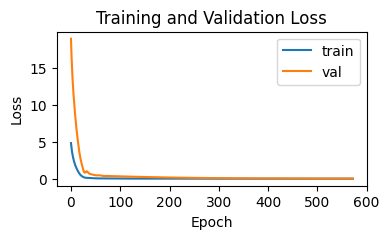

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 280
Best Val Loss after training: 0.02595360390841961


Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 544
Best Val Loss after training: 0.04301835224032402


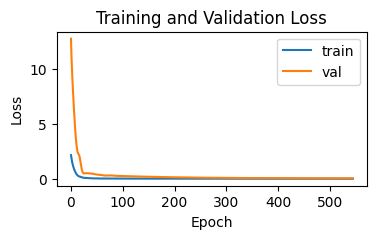

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 412
Best Val Loss after training: 0.03760490566492081


Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.10258238762617111


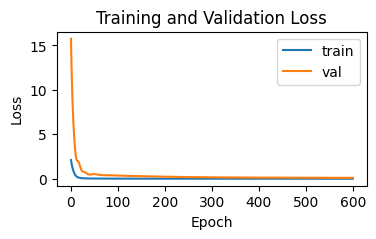

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 591
Best Val Loss after training: 0.031134609133005142


Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.08609520643949509


Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 549
Best Val Loss after training: 0.03863924369215965


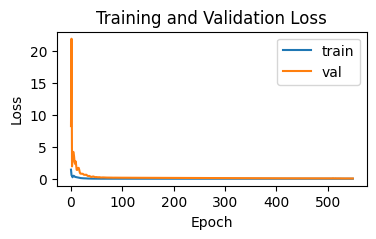

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.02595360390841961
Test loss for 1: 0.1537431925535202
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.027884977 24.460625
Predicted values range: 1.1256144e-05 21.566587
R² for 1: 0.9911039471626282
Slope for 1: 0.9446458104287184


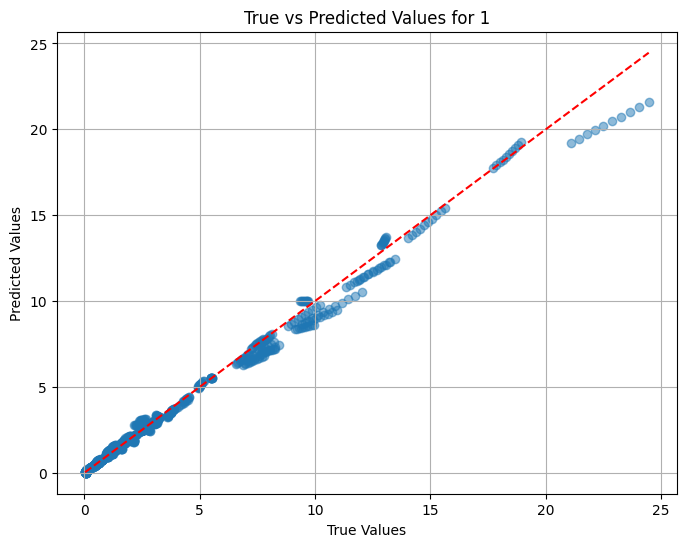

Working on Simulation Data:  2
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 585
Best Val Loss after training: 0.03972407802939415


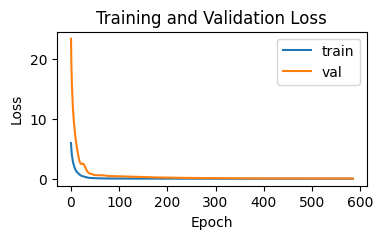

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 271
Best Val Loss after training: 0.025534188374876976


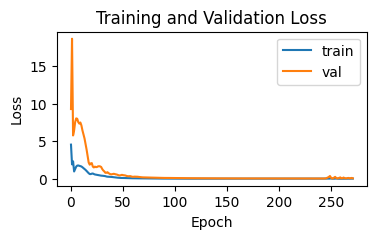

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 564
Best Val Loss after training: 0.0652160570025444


Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 239
Best Val Loss after training: 0.06121542677283287


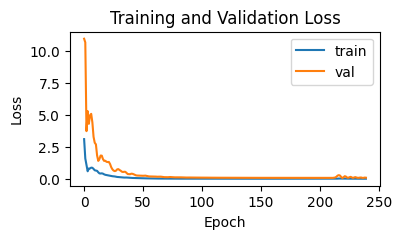

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.10302558541297913


Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 183
Best Val Loss after training: 0.08479193598031998


Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.09010548889636993


Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 474
Best Val Loss after training: 0.04587610065937042


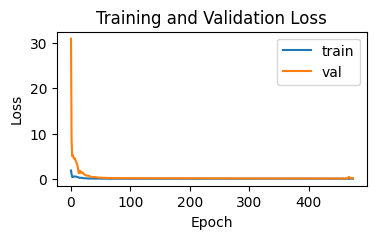

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.025534188374876976
Test loss for 2: 0.14870890974998474
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.054919116 25.159851
Predicted values range: 5.2614294e-05 24.002201
R² for 2: 0.9924492239952087
Slope for 2: 1.0255949069003587


Working on Simulation Data:  3
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 78
Best Val Loss after training: 0.24606953561306


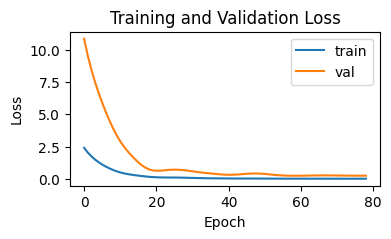

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 226
Best Val Loss after training: 0.014882978983223438


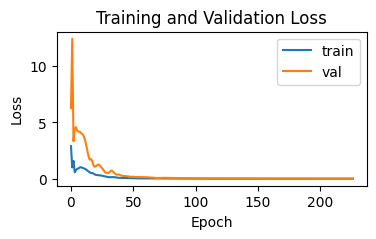

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 516
Best Val Loss after training: 0.03631487116217613


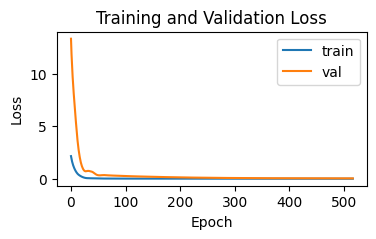

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 241
Best Val Loss after training: 0.032877374440431595


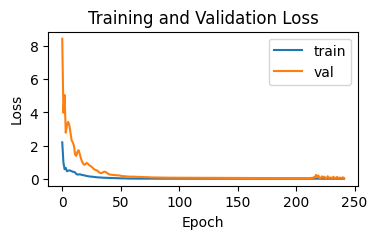

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.08094600588083267


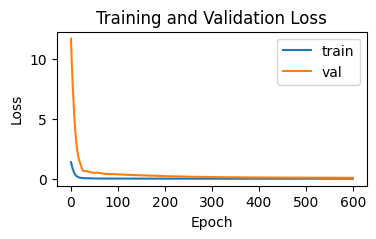

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 430
Best Val Loss after training: 0.03289525583386421


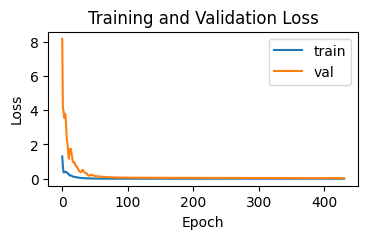

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.09654907137155533


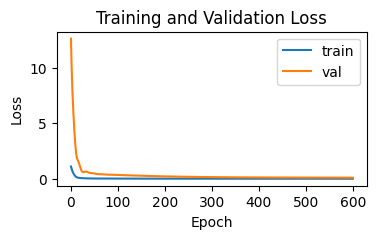

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 443
Best Val Loss after training: 0.0415588840842247


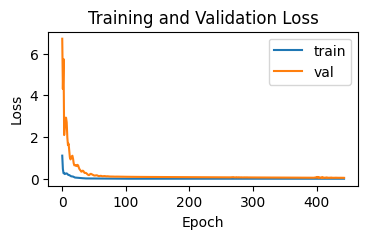

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.014882978983223438
Test loss for 3: 0.04996565729379654
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.019691698 22.136484
Predicted values range: 0.0042342646 22.562416
R² for 3: 0.9969521164894104
Slope for 3: 0.9844935635012468


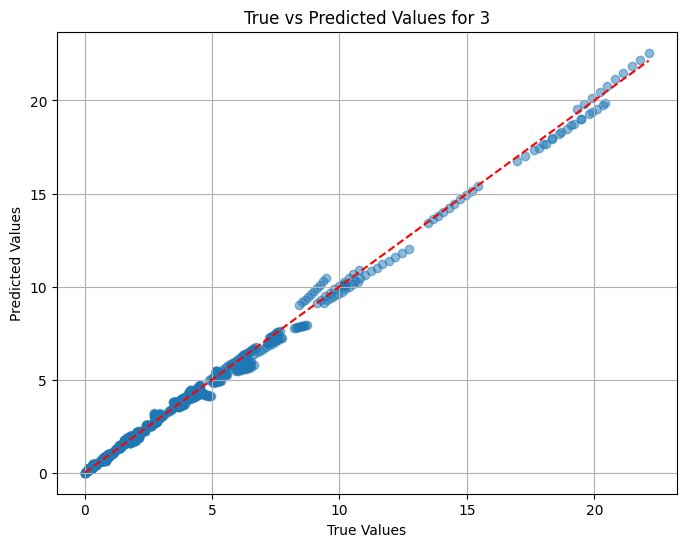

Working on Simulation Data:  4
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 448
Best Val Loss after training: 0.016080783680081367


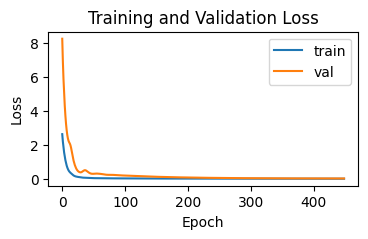

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 228
Best Val Loss after training: 0.013767505995929241


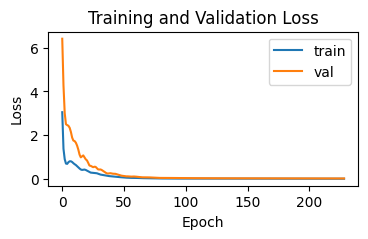

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 577
Best Val Loss after training: 0.03163585439324379


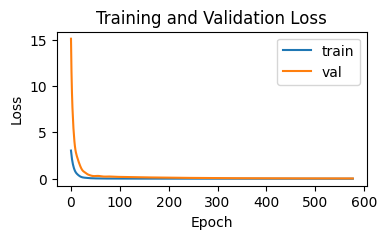

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 284
Best Val Loss after training: 0.02546655759215355


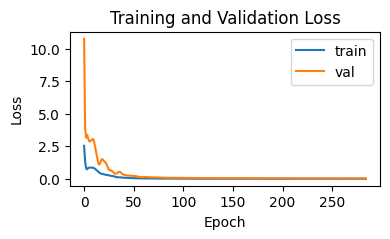

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 546
Best Val Loss after training: 0.04353763163089752


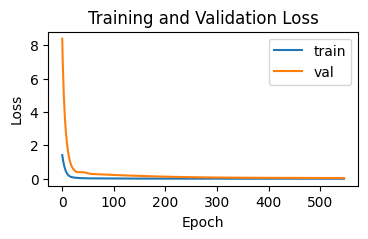

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 471
Best Val Loss after training: 0.021198991686105728


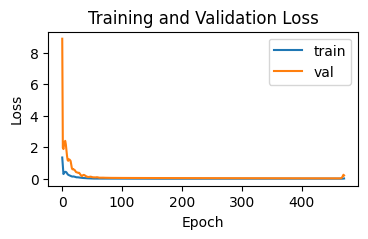

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 416
Best Val Loss after training: 0.048431407660245895


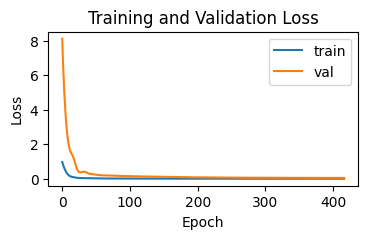

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 434
Best Val Loss after training: 0.023276830092072487


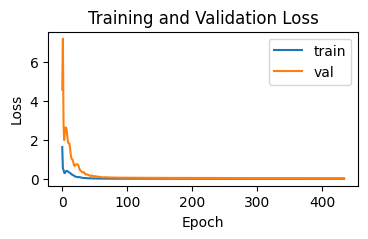

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.013767505995929241
Test loss for 4: 0.03888624534010887
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.020899124 13.759434
Predicted values range: 0.00029855166 13.552919
R² for 4: 0.9956613779067993
Slope for 4: 1.0016017471241314


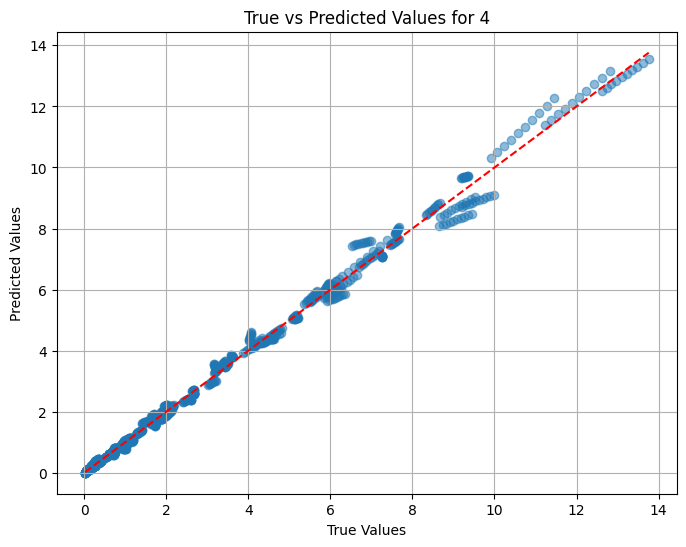

Working on Simulation Data:  5
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 508
Best Val Loss after training: 0.012006202712655067


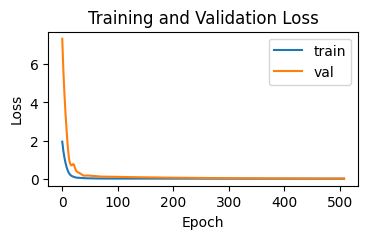

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 181
Best Val Loss after training: 0.007157972082495689


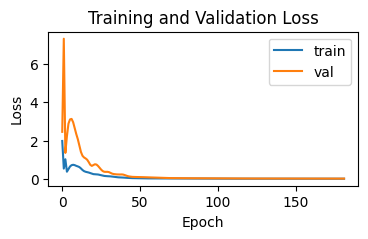

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 454
Best Val Loss after training: 0.02015477418899536


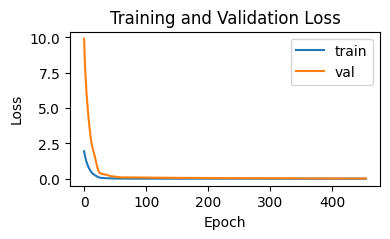

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 189
Best Val Loss after training: 0.015315806493163109


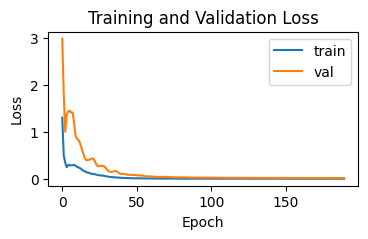

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 322
Best Val Loss after training: 0.023020917549729347


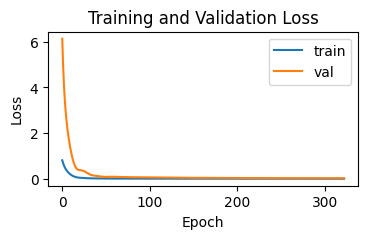

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 155
Best Val Loss after training: 0.025485437363386154


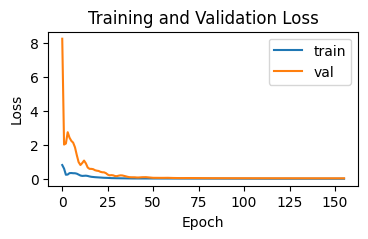

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 286
Best Val Loss after training: 0.027317188680171967


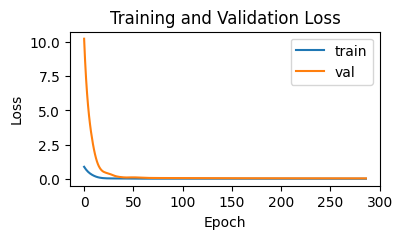

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 101
Best Val Loss after training: 0.027412662282586098


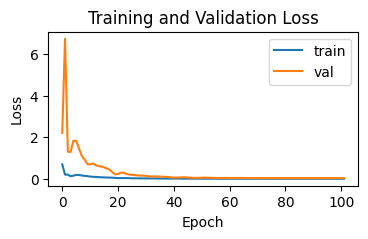

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.007157972082495689
Test loss for 5: 0.017589030787348747
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.01190613 14.683764
Predicted values range: 1.2016412e-05 14.2580185
R² for 5: 0.9982215166091919
Slope for 5: 0.98467532898065


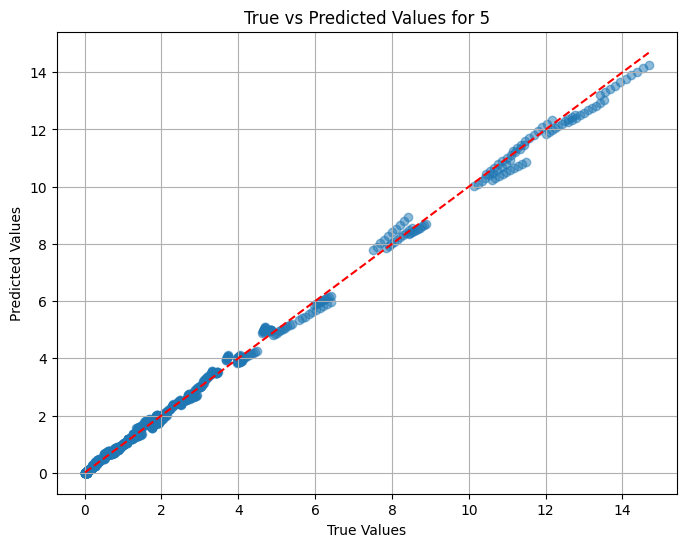

Working on Simulation Data:  6
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 503
Best Val Loss after training: 0.04975590854883194


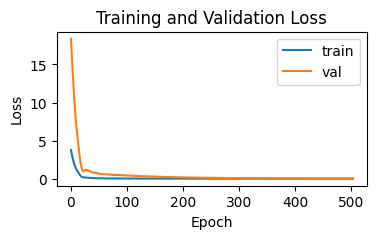

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 247
Best Val Loss after training: 0.0456133671104908


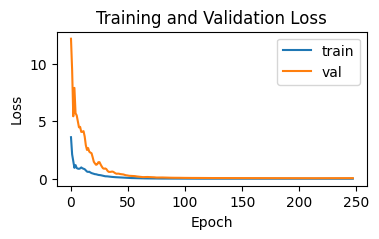

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.10834038257598877


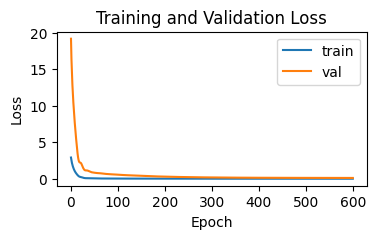

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 114
Best Val Loss after training: 0.10202208161354065


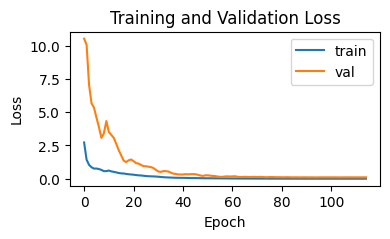

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 360
Best Val Loss after training: 0.12604257464408875


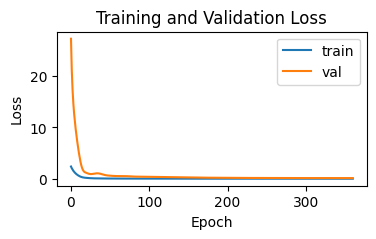

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 458
Best Val Loss after training: 0.0929252952337265


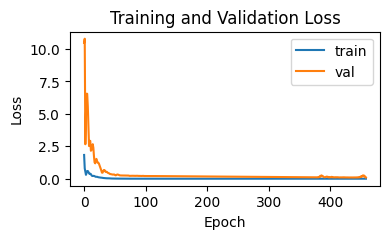

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 51
Best Val Loss after training: 0.6847197413444519


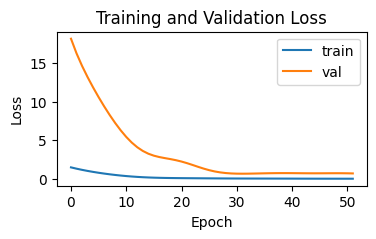

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 482
Best Val Loss after training: 0.06118304654955864


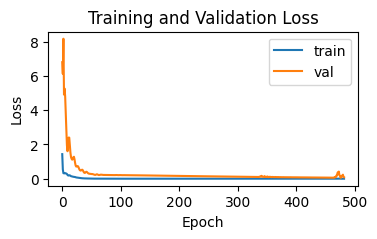

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.0456133671104908
Test loss for 6: 0.2167913168668747
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.013897251 24.60834
Predicted values range: 2.80651e-05 26.134062
R² for 6: 0.9914527535438538
Slope for 6: 1.0006637030990417


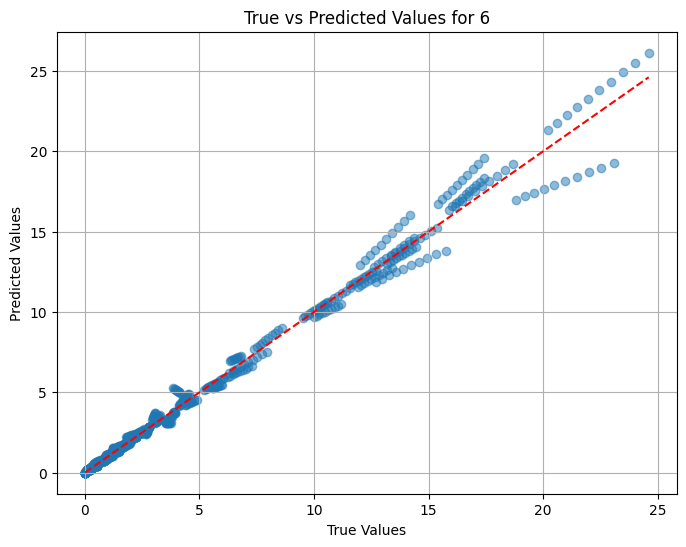

Working on Simulation Data:  7
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 423
Best Val Loss after training: 0.02282140403985977


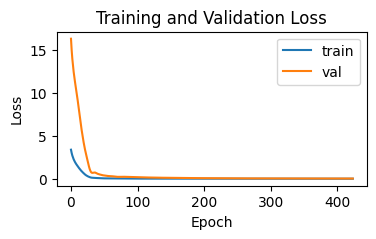

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 210
Best Val Loss after training: 0.02442118711769581


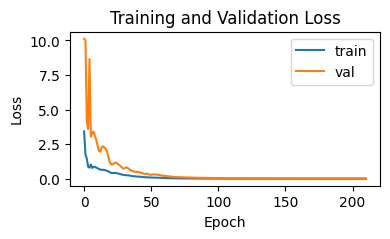

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 533
Best Val Loss after training: 0.06385601311922073


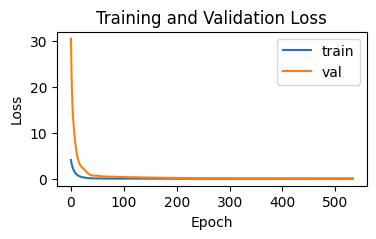

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 466
Best Val Loss after training: 0.04651419445872307


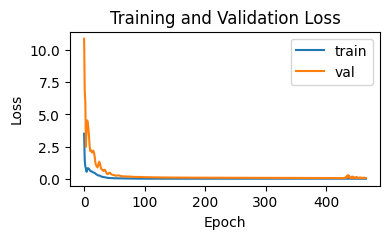

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 446
Best Val Loss after training: 0.10376082360744476


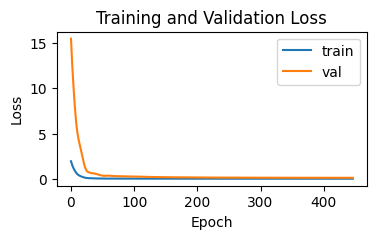

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 125
Best Val Loss after training: 0.09477684646844864


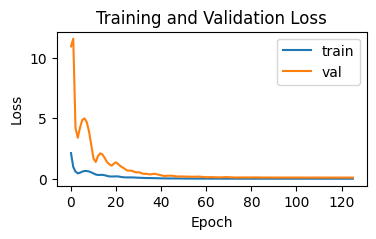

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 69
Best Val Loss after training: 0.259886771440506


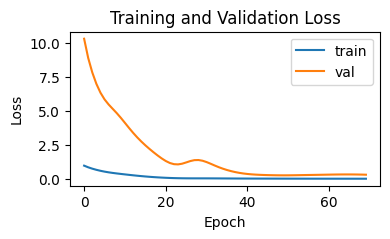

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.04801313951611519


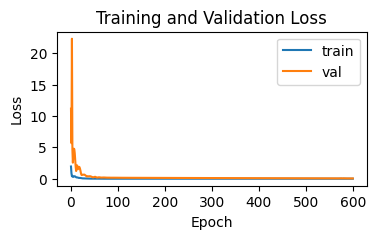

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.001}, Best validation loss: 0.02282140403985977
Test loss for 7: 0.08936461061239243
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.017728167 26.759712
Predicted values range: 0.021819143 24.542477
R² for 7: 0.9956304430961609
Slope for 7: 0.9862977338194039


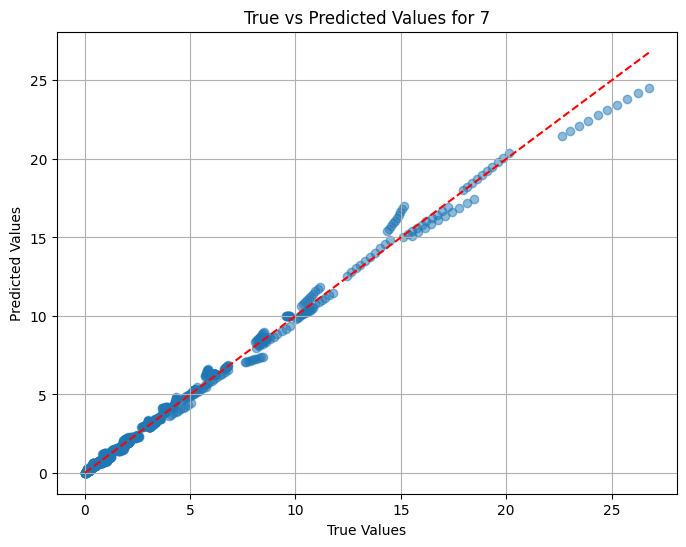

Working on Simulation Data:  8
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 412
Best Val Loss after training: 0.013997516594827175


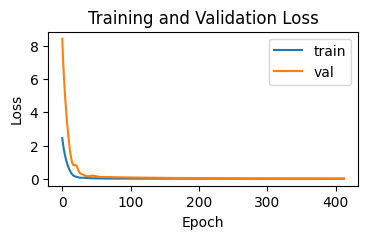

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 210
Best Val Loss after training: 0.011581921949982643


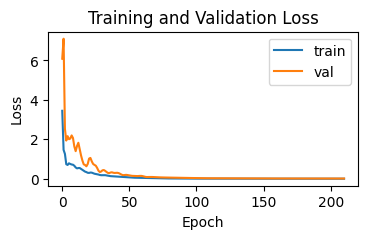

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 338
Best Val Loss after training: 0.035475075244903564


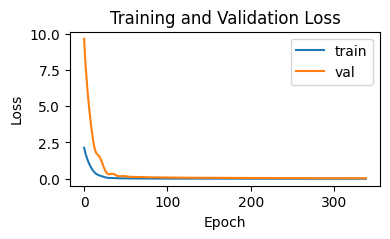

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 131
Best Val Loss after training: 0.024094820022583008


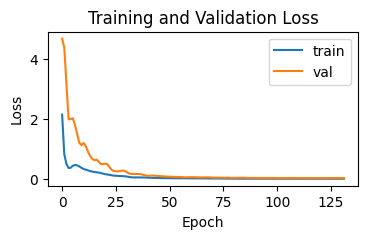

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 81
Best Val Loss after training: 0.09110084921121597


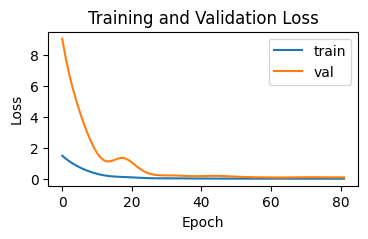

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 550
Best Val Loss after training: 0.019394736737012863


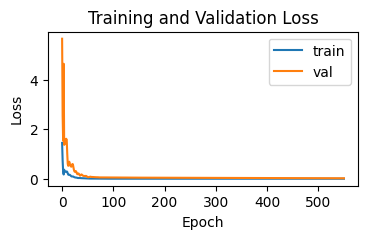

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 75
Best Val Loss after training: 0.08123776316642761


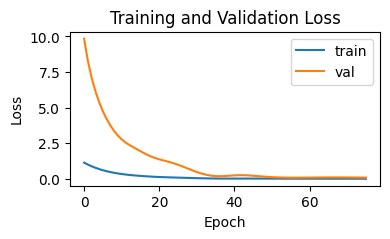

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.014757199212908745


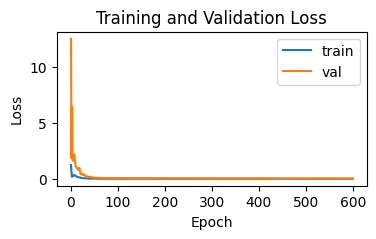

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.011581921949982643
Test loss for 8: 0.02731212042272091
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.013662884 15.795745
Predicted values range: 4.9354685e-07 14.955025
R² for 8: 0.9974867105484009
Slope for 8: 0.9943190880841128


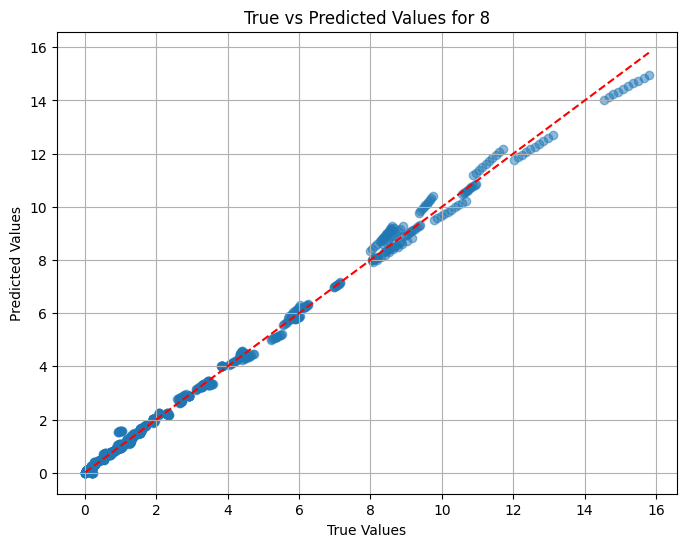

Working on Simulation Data:  9
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 432
Best Val Loss after training: 0.01953127421438694


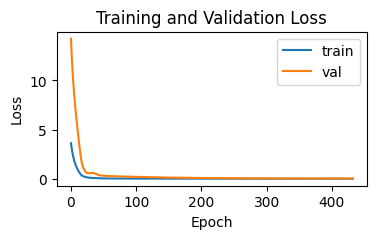

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 175
Best Val Loss after training: 0.01629517413675785


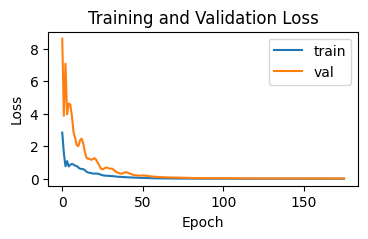

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 425
Best Val Loss after training: 0.02970775030553341


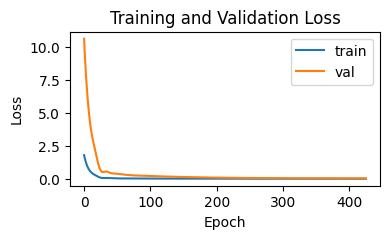

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 242
Best Val Loss after training: 0.026869095861911774


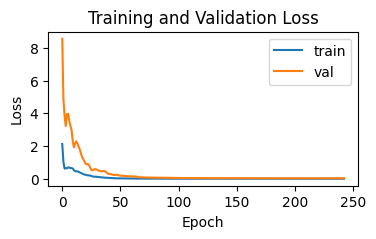

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 46
Best Val Loss after training: 0.43828335404396057


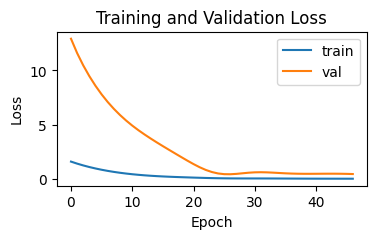

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 419
Best Val Loss after training: 0.02435050718486309


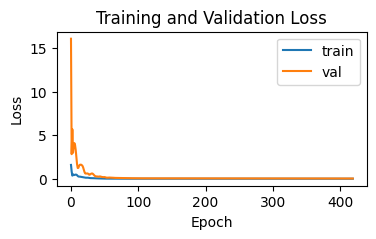

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 576
Best Val Loss after training: 0.05288318917155266


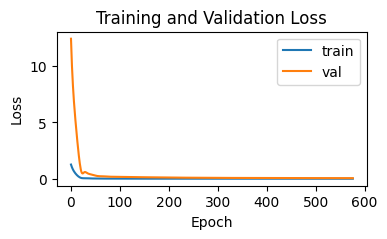

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 117
Best Val Loss after training: 0.07423081994056702


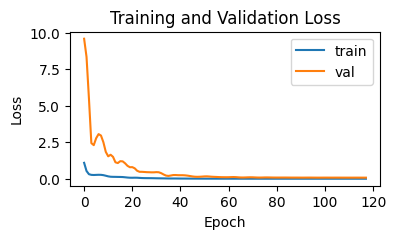

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.01629517413675785
Test loss for 9: 0.058654725551605225
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.00868911 25.286657
Predicted values range: 6.036287e-06 26.309464
R² for 9: 0.9960193037986755
Slope for 9: 1.0172088812274798


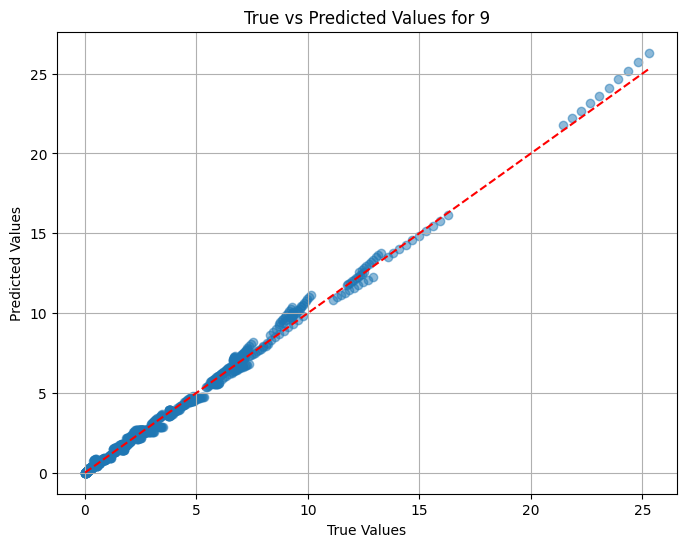

Working on Simulation Data:  10
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 392
Best Val Loss after training: 0.010916967876255512


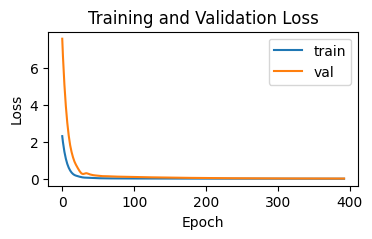

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 241
Best Val Loss after training: 0.006696769036352634


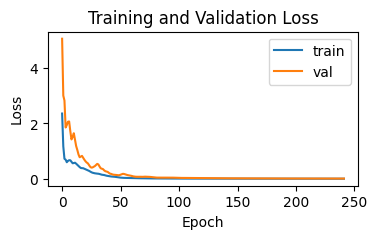

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 381
Best Val Loss after training: 0.019393621012568474


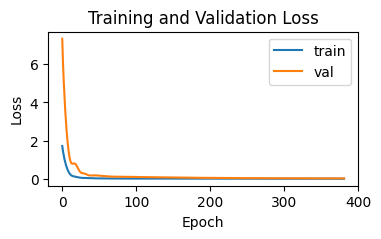

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 167
Best Val Loss after training: 0.012511990033090115


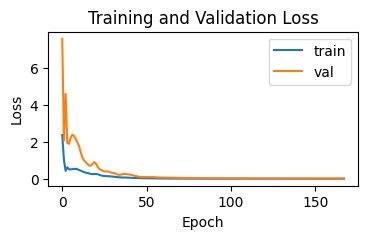

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 368
Best Val Loss after training: 0.022843265905976295


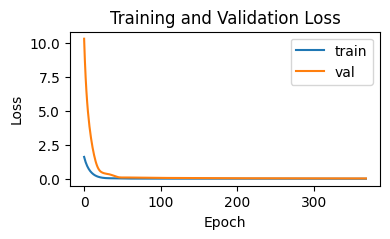

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 141
Best Val Loss after training: 0.014295326545834541


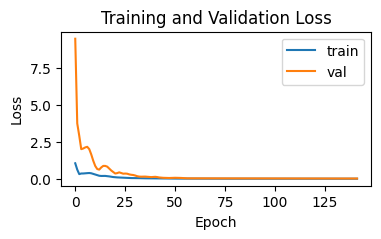

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 289
Best Val Loss after training: 0.028572876006364822


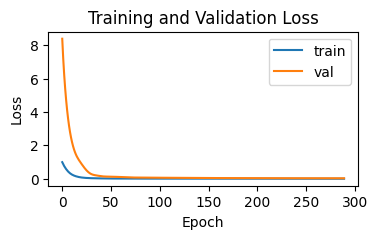

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 157
Best Val Loss after training: 0.018631020560860634


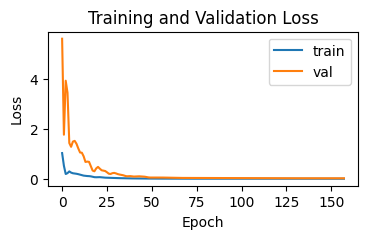

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.006696769036352634
Test loss for 10: 0.016155479475855827
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.01935141 14.54012
Predicted values range: 5.733647e-06 14.022391
R² for 10: 0.9983744621276855
Slope for 10: 0.9935518780696904


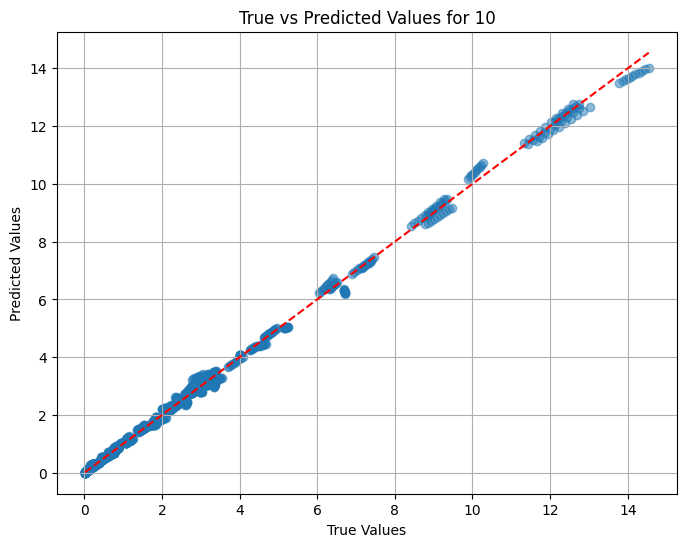

Working on Simulation Data:  11
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 521
Best Val Loss after training: 0.028813764452934265


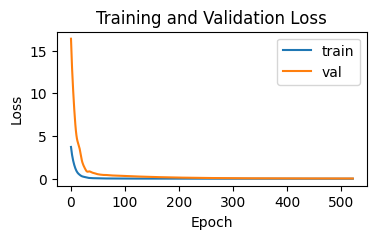

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 231
Best Val Loss after training: 0.025866886600852013


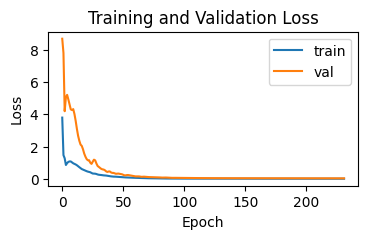

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.08244580775499344


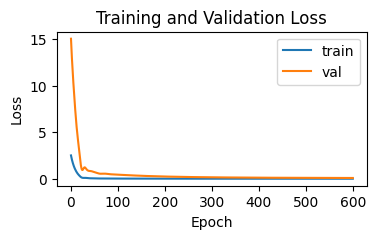

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 495
Best Val Loss after training: 0.05467183142900467


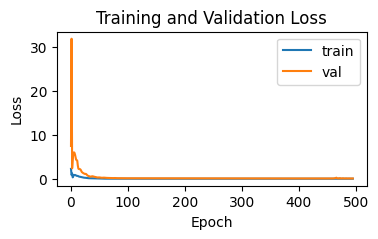

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 571
Best Val Loss after training: 0.13437919318675995


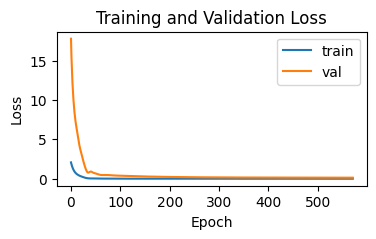

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 470
Best Val Loss after training: 0.05385565385222435


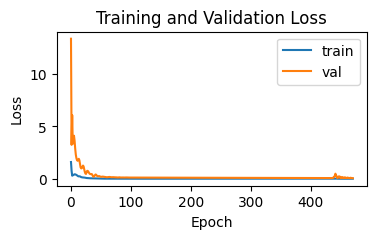

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.1265789270401001


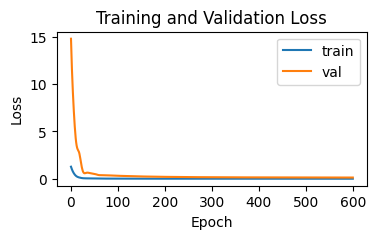

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.04652437940239906


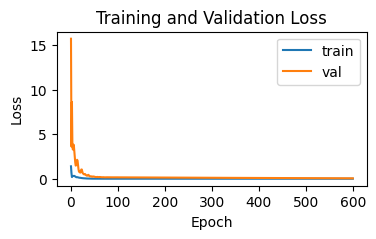

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.025866886600852013
Test loss for 11: 0.1183505654335022
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.0006776735 22.627113
Predicted values range: 2.0620621e-07 21.52249
R² for 11: 0.9936443567276001
Slope for 11: 0.9895263598147022


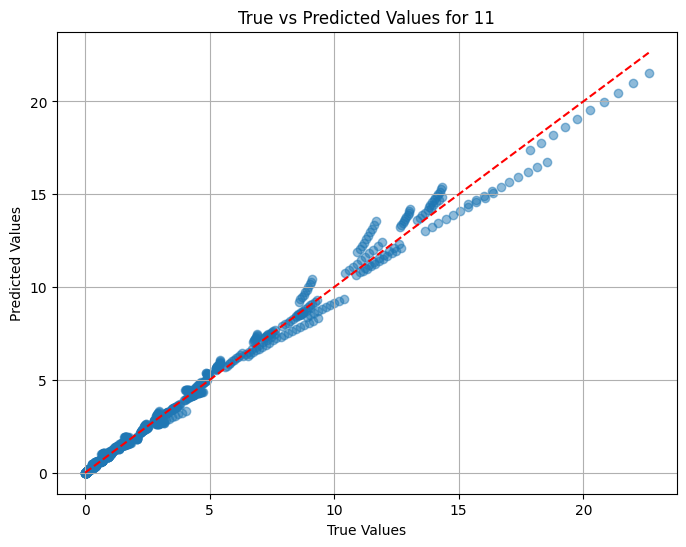

Working on Simulation Data:  12
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 422
Best Val Loss after training: 0.012906473129987717


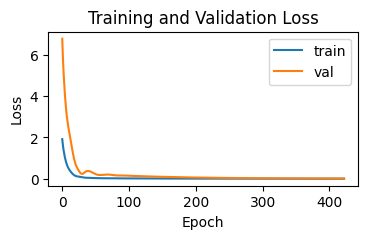

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 215
Best Val Loss after training: 0.008861685171723366


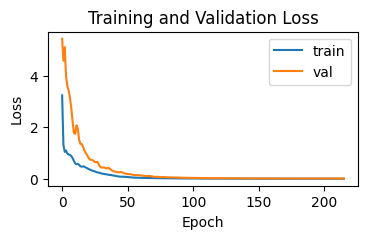

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 60
Best Val Loss after training: 0.1945546269416809


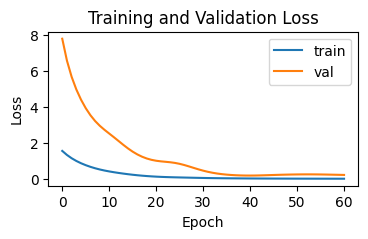

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 184
Best Val Loss after training: 0.019376326352357864


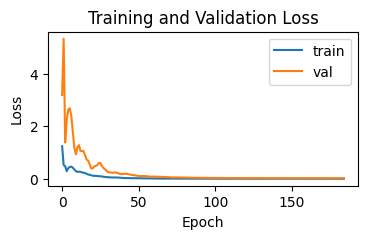

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 327
Best Val Loss after training: 0.03323618322610855


Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 208
Best Val Loss after training: 0.027183683589100838


Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 408
Best Val Loss after training: 0.04179520532488823


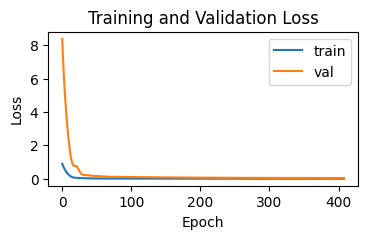

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 114
Best Val Loss after training: 0.03021114133298397


Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.008861685171723366
Test loss for 12: 0.024982143193483353
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.04647508 21.272429
Predicted values range: 5.9929956e-05 22.087263
R² for 12: 0.9975907802581787
Slope for 12: 1.0112542638093993


Working on Simulation Data:  13
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 393
Best Val Loss after training: 0.030883878469467163


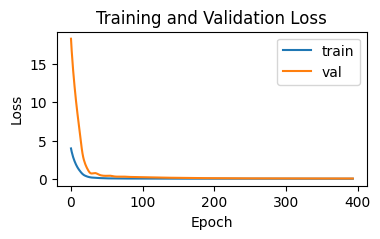

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 192
Best Val Loss after training: 0.027141699567437172


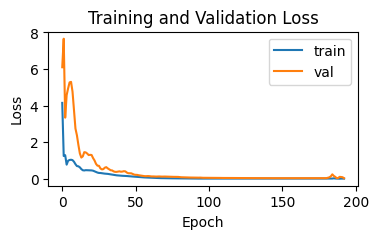

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 495
Best Val Loss after training: 0.08519499003887177


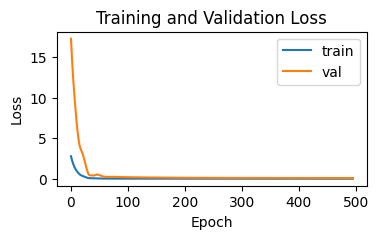

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 540
Best Val Loss after training: 0.03397795185446739


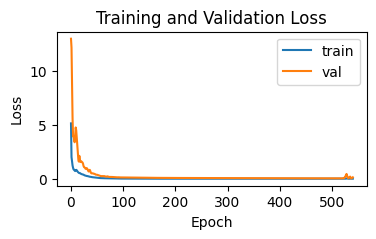

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 321
Best Val Loss after training: 0.08103875815868378


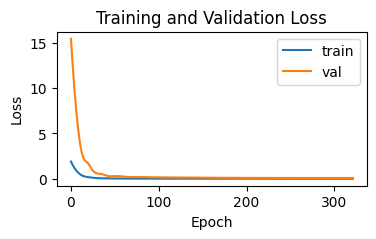

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 489
Best Val Loss after training: 0.03016073815524578


Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.08939128369092941


Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 98
Best Val Loss after training: 0.12575627863407135


Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.027141699567437172
Test loss for 13: 0.09475991874933243
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.0031709722 27.054962
Predicted values range: 5.1700486e-06 27.203857
R² for 13: 0.9958563446998596
Slope for 13: 1.001148223869867


Working on Simulation Data:  14
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 514
Best Val Loss after training: 0.060383185744285583


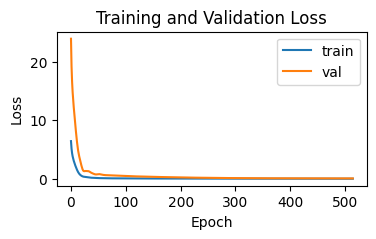

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 244
Best Val Loss after training: 0.038339145481586456


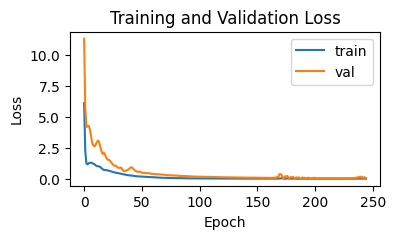

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.10488820821046829


Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 283
Best Val Loss after training: 0.05466384440660477


Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.19952327013015747


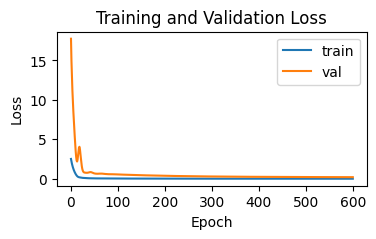

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 80
Best Val Loss after training: 0.2033235877752304


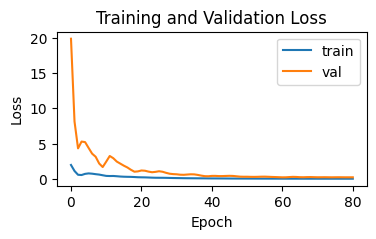

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 69
Best Val Loss after training: 0.3516755700111389


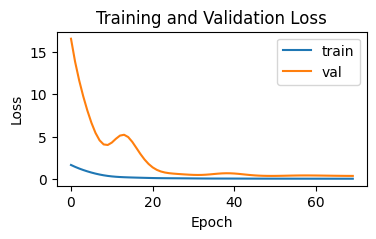

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 89
Best Val Loss after training: 0.22163288295269012


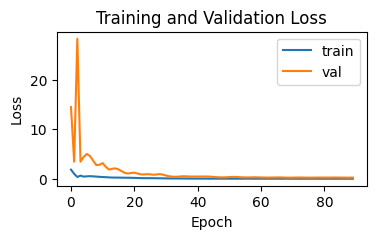

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.038339145481586456
Test loss for 14: 0.13589519262313843
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.0011867075 28.091711
Predicted values range: 2.3699492e-08 29.08261
R² for 14: 0.9930881261825562
Slope for 14: 0.9781659448562722


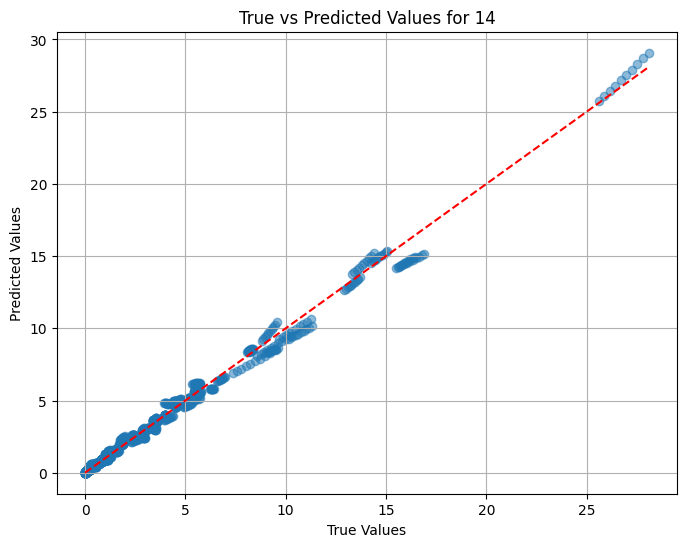

Working on Simulation Data:  15
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 487
Best Val Loss after training: 0.022867897525429726


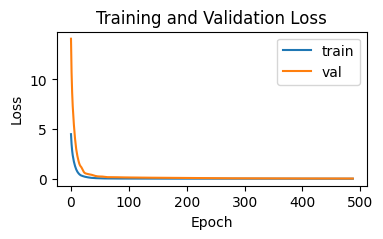

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 216
Best Val Loss after training: 0.014318949542939663


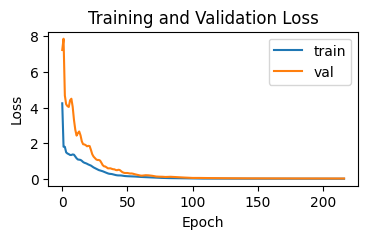

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 477
Best Val Loss after training: 0.03266486898064613


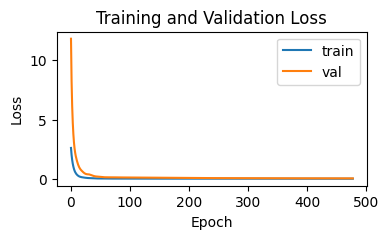

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 227
Best Val Loss after training: 0.027064142748713493


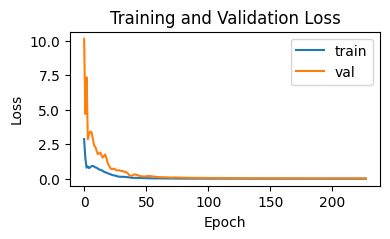

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 84
Best Val Loss after training: 0.12931208312511444


Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 353
Best Val Loss after training: 0.025484226644039154


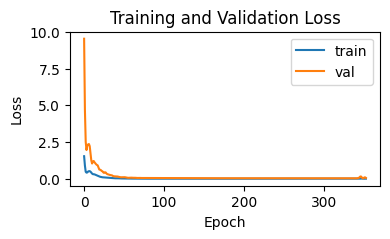

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 74
Best Val Loss after training: 0.12456508725881577


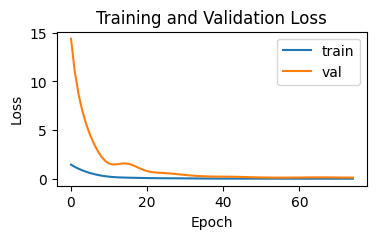

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 425
Best Val Loss after training: 0.02642335183918476


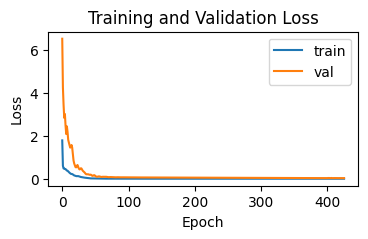

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.014318949542939663
Test loss for 15: 0.03457579389214516
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.034416474 13.106497
Predicted values range: 4.091811e-06 13.552468
R² for 15: 0.9965688586235046
Slope for 15: 0.996909066795471


Working on Simulation Data:  16
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 495
Best Val Loss after training: 0.015532344579696655


Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 202
Best Val Loss after training: 0.010017410852015018


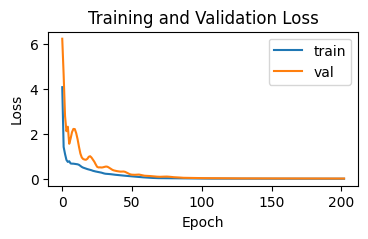

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 439
Best Val Loss after training: 0.01664687693119049


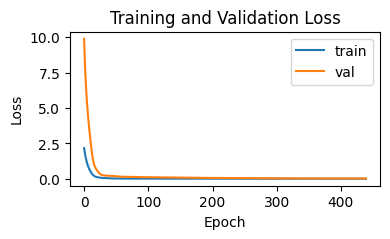

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 205
Best Val Loss after training: 0.0172871220856905


Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 334
Best Val Loss after training: 0.031241802498698235


Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 128
Best Val Loss after training: 0.03341278061270714


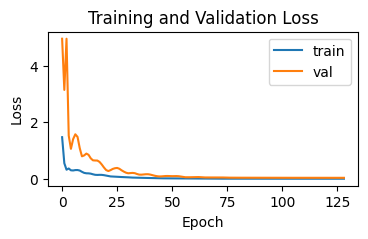

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 379
Best Val Loss after training: 0.039334628731012344


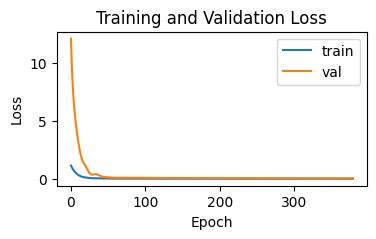

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 117
Best Val Loss after training: 0.0450565442442894


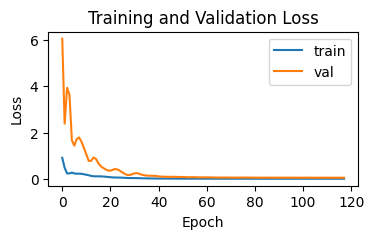

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.010017410852015018
Test loss for 16: 0.022450920194387436
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.02545887 19.274794
Predicted values range: 0.008533425 20.08861
R² for 16: 0.9976804852485657
Slope for 16: 1.0155865254536296


Working on Simulation Data:  17
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 456
Best Val Loss after training: 0.025215959176421165


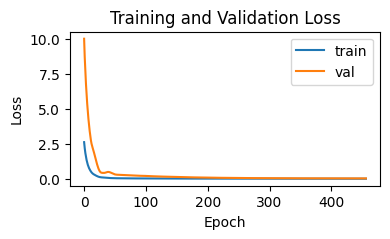

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 162
Best Val Loss after training: 0.013061804696917534


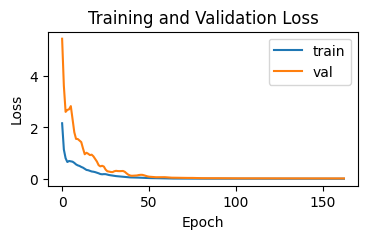

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 317
Best Val Loss after training: 0.062064167112112045


Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 300
Best Val Loss after training: 0.02903502807021141


Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.08068843185901642


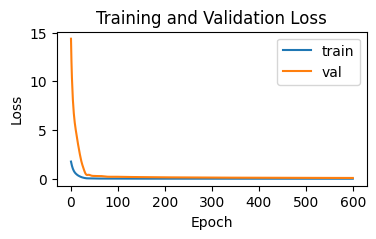

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 383
Best Val Loss after training: 0.022207321599125862


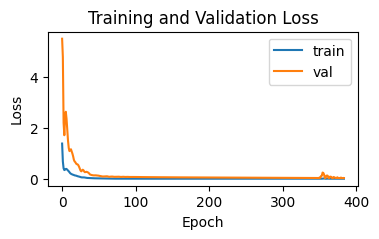

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 472
Best Val Loss after training: 0.04983293265104294


Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 549
Best Val Loss after training: 0.011540818028151989


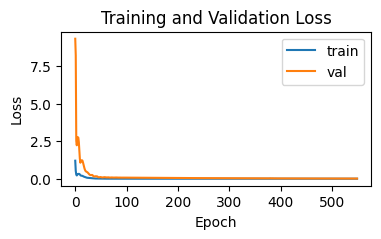

Best hyperparameters: {'batch_time': 119, 'batch_size': 61, 'learning_rate': 0.01}, Best validation loss: 0.011540818028151989
Test loss for 17: 0.028562434017658234
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.0142508475 18.178099
Predicted values range: 0.015443989 18.026947
R² for 17: 0.9974362254142761
Slope for 17: 0.9994520980151822


Working on Simulation Data:  18
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.05929918214678764


Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 263
Best Val Loss after training: 0.047885630279779434


Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.16573990881443024


Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 590
Best Val Loss after training: 0.06912808865308762


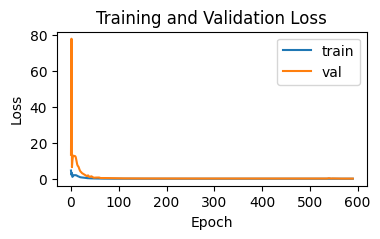

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.14944839477539062


Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.05941203609108925


Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 63
Best Val Loss after training: 0.6758161187171936


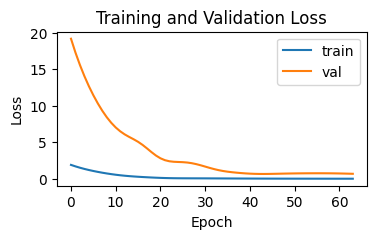

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 429
Best Val Loss after training: 0.048418041318655014


Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.047885630279779434
Test loss for 18: 0.2769397497177124
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.0069502653 23.775194
Predicted values range: 1.0257289e-05 24.30944
R² for 18: 0.9887745380401611
Slope for 18: 1.0200797022735646


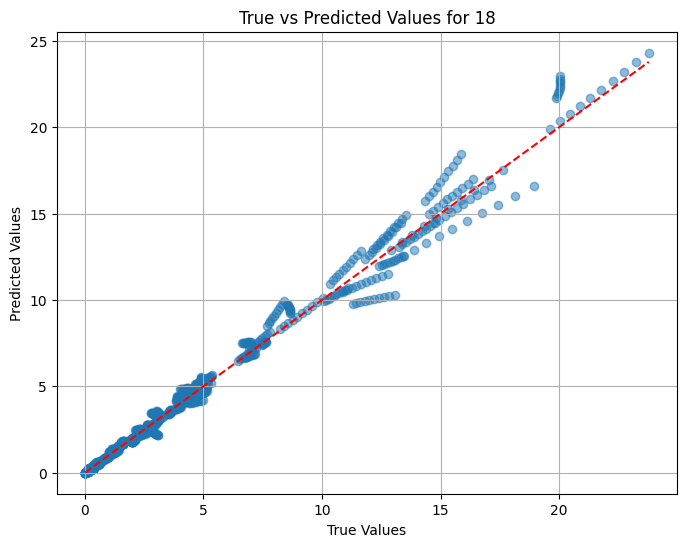

Working on Simulation Data:  19
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 551
Best Val Loss after training: 0.04343516752123833


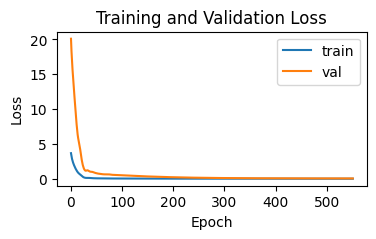

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 246
Best Val Loss after training: 0.03640776500105858


Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.13617703318595886


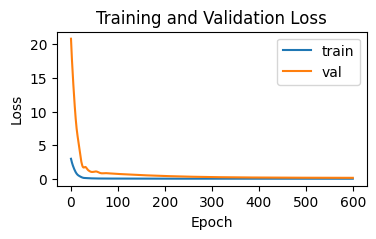

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 213
Best Val Loss after training: 0.09513707458972931


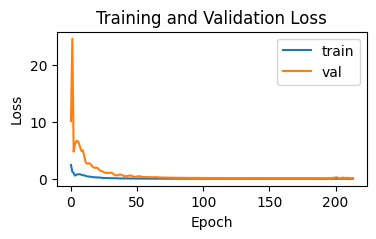

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.2106470763683319


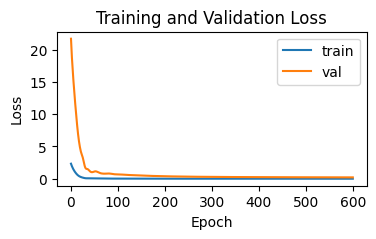

Training with batch_time=139, batch_size=41, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.08374518901109695


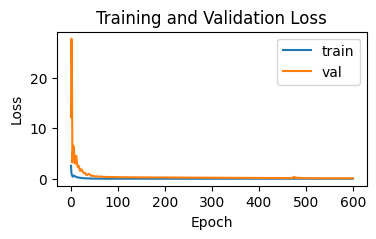

Training with batch_time=119, batch_size=61, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Best Val Loss after training: 0.23368042707443237


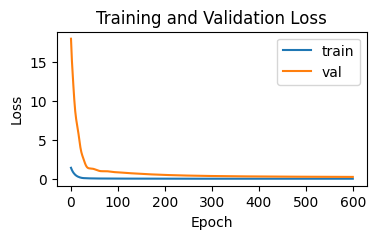

Training with batch_time=119, batch_size=61, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 533
Best Val Loss after training: 0.06564311683177948


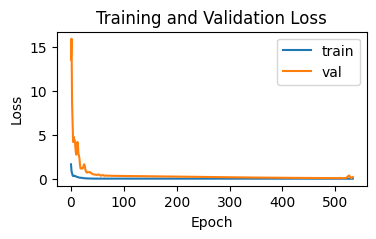

Best hyperparameters: {'batch_time': 179, 'batch_size': 1, 'learning_rate': 0.01}, Best validation loss: 0.03640776500105858
Test loss for 19: 0.4304717481136322
Shape of true values: (10, 100)
Shape of predicted values: (10, 100)
True values range: 0.004618445 25.94124
Predicted values range: 4.1270152e-05 25.948069
R² for 19: 0.9847254157066345
Slope for 19: 0.9254801327807651


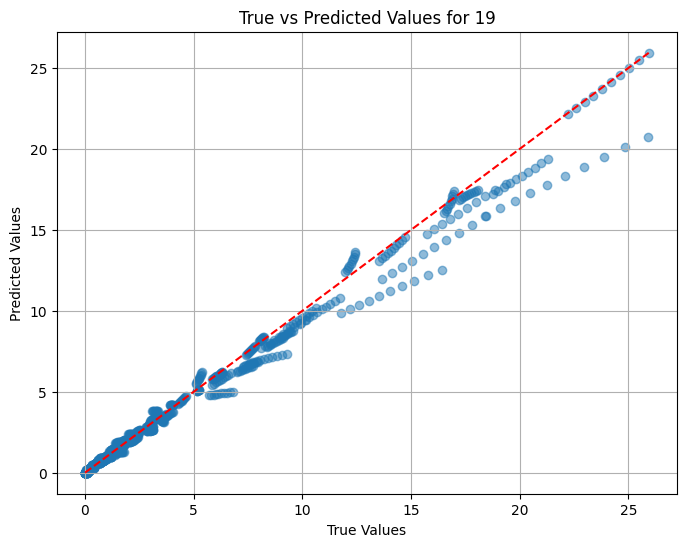

Working on Simulation Data:  20
Training with batch_time=179, batch_size=1, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 506
Best Val Loss after training: 0.018548421561717987


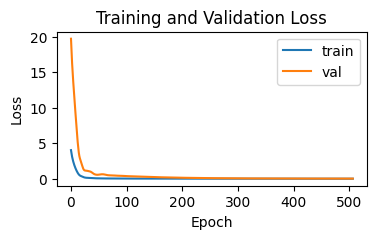

Training with batch_time=179, batch_size=1, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 123
Best Val Loss after training: 0.026795750483870506


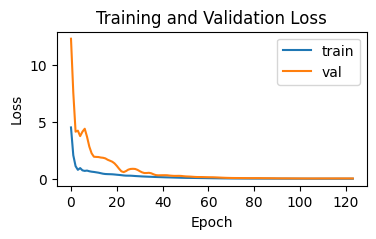

Training with batch_time=159, batch_size=21, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 592
Best Val Loss after training: 0.03202526271343231


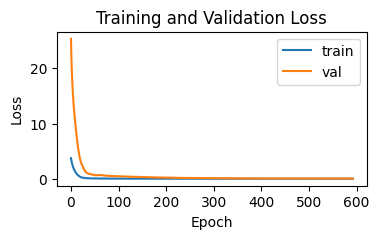

Training with batch_time=159, batch_size=21, lr=0.01


  0%|          | 0/601 [00:00<?, ?it/s]

Early stopping at epoch 447
Best Val Loss after training: 0.02326737716794014


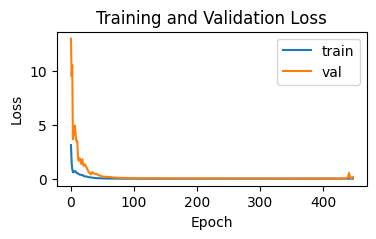

Training with batch_time=139, batch_size=41, lr=0.001


  0%|          | 0/601 [00:00<?, ?it/s]

In [ ]:
r_2_all = []
slope_all = []


for sim_data in key:

  result = sim_results[sim_data]

  e = result['e'].transpose(0, 1)
  x = result['pred_y'].squeeze(1)
  t = result['t']

  m = x.shape[1]

  train_x, val_x, test_x, train_e, val_e, test_e = data_split(x, e, test_time_points, val_time_points)

  print("Working on Simulation Data: ", sim_data)

  # Define hyperparameters
  hyperparameters = [
      (179, 1, 0.001), (179, 1, 0.01), (159, 21, 0.001), (159, 21, 0.01),
      (139, 41, 0.001), (139, 41, 0.01), (119, 61, 0.001), (119, 61, 0.01)]  # (batch_time, batch_size, learning_rate)

  best_model_state, best_hyperparams, best_val_loss = train_and_optimize_model(GLVModel,
                             hyperparameters,
                             get_batch, train_x, train_e,
                             x, e, t_val, train_time_points, val_time_points, val_x,
                             niters=600, early_stopping_patience=20, early_stopping_min_delta=1e-3, model_args=(m,))

  # Load the best model state
  best_model = GLVModel(m)
  best_model.load_state_dict(best_model_state)
  best_model.eval()

  # Predict the test data
  with torch.no_grad():
    y_pred_test = odeint_adjoint(best_model, x.unsqueeze(1)[0, :, :], t_test, rtol=1e-3, atol=1e-4, method='euler')
    test_loss = torch.mean(torch.square(y_pred_test[train_time_points + val_time_points:, :, :] - test_x.unsqueeze(1)))

  print(f"Test loss for {sim_data}: {test_loss.item()}")

  # Calculate R² and slope
  true_values = test_x.unsqueeze(1).squeeze().numpy()
  predicted_values = y_pred_test[train_time_points + val_time_points:, :, :].squeeze().numpy()

  # Print shapes of true and predicted values
  print("Shape of true values:", true_values.shape)
  print("Shape of predicted values:", predicted_values.shape)

  # Check min and max of true and predicted values
  print("True values range:", true_values.min(), true_values.max())
  print("Predicted values range:", predicted_values.min(), predicted_values.max())

  r2 = r2_score(true_values.flatten(), predicted_values.flatten())
  slope, intercept = np.polyfit(true_values.flatten(), predicted_values.flatten(), 1)

  r_2_all.append(r2)
  slope_all.append(slope)

  print(f"R² for {sim_data}: {r2}")
  print(f"Slope for {sim_data}: {slope}")

   # Plot true vs predicted
  plt.figure(figsize=(8, 6))
  plt.scatter(true_values.flatten(), predicted_values.flatten(), alpha=0.5)
  plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--')
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.title(f'True vs Predicted Values for {sim_data}')
  plt.grid(True)
  plt.show()

So far best hyperparameters are batch time = 179, batch size = 1 and lr = 0.01

In [ ]:
r_2_all

[0.9931741952896118]

In [ ]:
slope_all

[1.0153552405072317]

In [ ]:
GLV_on_sim_results_dict = {
        'r2': r_2_all,
        'slope': slope_all
    }

In [ ]:
GLV_on_sim_results_dict

In [ ]:
with open('GLV_on_sim_results_dict.pkl', 'wb') as f:
    pickle.dump(GLV_on_sim_results_dict, f)